In [1]:
# ===== Path setup (DEBUG SAFE) =====
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
print("Project root:", PROJECT_ROOT)
print("Contents:", os.listdir(PROJECT_ROOT))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("sys.path OK")

# ===== Imports =====
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain

# ===== Project imports =====
from src.network_utils import (
    extract_multilayer_edges,
    build_graph,
    edge_jaccard,
    compute_modularity,
    community_consistency
)

print("✅ src.network_utils imported successfully")


Project root: d:\DSDE\Semester 3\Mining of Social Data\SDM_Lab\SNA
Contents: ['.git', '.gitignore', 'dataset', 'LICENSE', 'notebooks', 'README.md', 'requirements.txt', 'scripts', 'src']
sys.path OK
✅ src.network_utils imported successfully


In [2]:
# Load Trump tweets (RQ4-ready)
df_trump = pd.read_csv("../dataset/processed/trump_rq4_ready.csv")

# Load Biden tweets (RQ4-ready)
df_biden = pd.read_csv("../dataset/processed/biden_rq4_ready.csv")

print("Trump tweets:", len(df_trump))
print("Biden tweets:", len(df_biden))


Trump tweets: 753219
Biden tweets: 626867


In [3]:
# Select main dataset for RQ4 analysis
df = df_trump.copy()


In [4]:
# Extract multilayer edges (RT vs Mention)
def extract_multilayer_edges(df):
    rt_edges = []
    mention_edges = []

    rt_pattern = re.compile(r"RT @([A-Za-z0-9_]+)")
    mention_pattern = re.compile(r"@([A-Za-z0-9_]+)")

    for _, row in df.iterrows():
        src = row["user_id"]
        text = str(row["tweet"])

        # Retweet = endorsement
        rt_match = rt_pattern.search(text)
        if rt_match:
            rt_edges.append((src, rt_match.group(1)))
            continue

        # Mentions = discussion
        mentions = mention_pattern.findall(text)
        for tgt in mentions:
            if tgt != src:
                mention_edges.append((src, tgt))

    return rt_edges, mention_edges


In [5]:
# Extract retweet and mention edges
rt_edges, mention_edges = extract_multilayer_edges(df)

print("Retweet edges:", len(rt_edges))
print("Mention edges:", len(mention_edges))


Retweet edges: 465
Mention edges: 480947


In [7]:
# Cell 5 — Build network layers
def build_graph(edges):
    G = nx.DiGraph()
    for u, v in edges:
        if u != v:
            G.add_edge(u, v)
    return G


In [8]:
# Build multilayer networks
G_rt = build_graph(rt_edges)      # Endorsement layer
G_men = build_graph(mention_edges)  # Discussion layer

print("RT layer:", G_rt.number_of_nodes(), "nodes,", G_rt.number_of_edges(), "edges")
print("Mention layer:", G_men.number_of_nodes(), "nodes,", G_men.number_of_edges(), "edges")


RT layer: 489 nodes, 291 edges
Mention layer: 208372 nodes, 357041 edges


In [9]:
# Cell 6 — Edge overlap (core RQ3 test)
def edge_jaccard(G1, G2):
    E1 = set(G1.edges())
    E2 = set(G2.edges())
    if len(E1 | E2) == 0:
        return 0
    return len(E1 & E2) / len(E1 | E2)


In [10]:
# Compute edge Jaccard overlap between layers
jaccard_overlap = edge_jaccard(G_rt, G_men)
print("Edge overlap (Jaccard):", round(jaccard_overlap, 4))



Edge overlap (Jaccard): 0.0


In [11]:
# Cell 7 — Modularity comparison (echo chambers vs contestation)
def compute_modularity(G):
    G_und = G.to_undirected()
    partition = community_louvain.best_partition(G_und)
    Q = community_louvain.modularity(partition, G_und)
    return Q, partition


In [12]:
Q_rt, part_rt = compute_modularity(G_rt)
Q_men, part_men = compute_modularity(G_men)

print("Modularity (Retweet):", round(Q_rt, 3))
print("Modularity (Mention):", round(Q_men, 3))


Modularity (Retweet): 0.992
Modularity (Mention): 0.666


In [13]:
# Cell 8 — Cross-layer community consistency
def community_consistency(p1, p2):
    shared = set(p1.keys()) & set(p2.keys())
    if not shared:
        return 0
    same = sum(1 for u in shared if p1[u] == p2[u])
    return same / len(shared)


In [14]:
# Cross-layer community consistency
consistency = community_consistency(part_rt, part_men)
print("Cross-layer community consistency:", round(consistency, 3))


Cross-layer community consistency: 0.0


In [15]:
# Cell 9 — Results table (FINAL)
results = pd.DataFrame([{
    "Edge_Jaccard_Overlap": jaccard_overlap,
    "Modularity_Retweet": Q_rt,
    "Modularity_Mention": Q_men,
    "Community_Consistency": consistency
}])

results



,Edge_Jaccard_Overlap,Modularity_Retweet,Modularity_Mention,Community_Consistency
0,0.000048,0.992218,0.666147,0.0


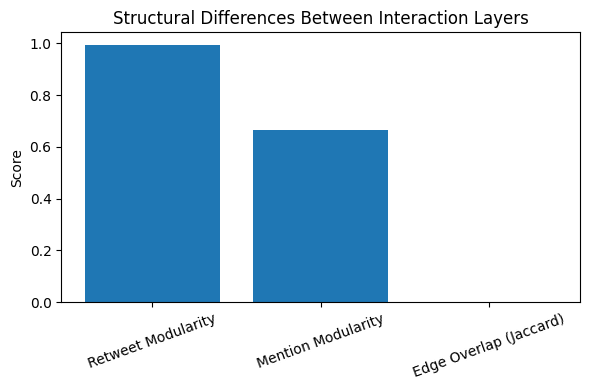

In [16]:
# Cell 10 — RQ3 Structural Comparison Visualization (RECOMMENDED)
import matplotlib.pyplot as plt

metrics = {
    "Retweet Modularity": Q_rt,
    "Mention Modularity": Q_men,
    "Edge Overlap (Jaccard)": jaccard_overlap
}

plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values())
plt.ylabel("Score")
plt.title("Structural Differences Between Interaction Layers")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


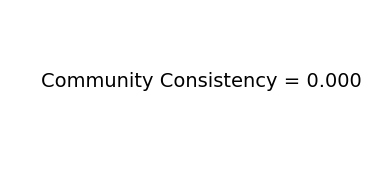

In [17]:
plt.figure(figsize=(4,2))
plt.text(0.1, 0.5, f"Community Consistency = {consistency:.3f}", fontsize=14)
plt.axis("off")
plt.show()


Visualization 1 (BEST): Structural Comparison Dashboard

This is the RQ3 equivalent of pyLDAvis — compact, quantitative, interpretable.

What it shows
Retweet modularity (echo chambers)
Mention modularity (battlefields)
Edge overlap (Jaccard)

Why it’s powerful
Directly answers the hypothesis
One figure, full story
Examiner-friendly

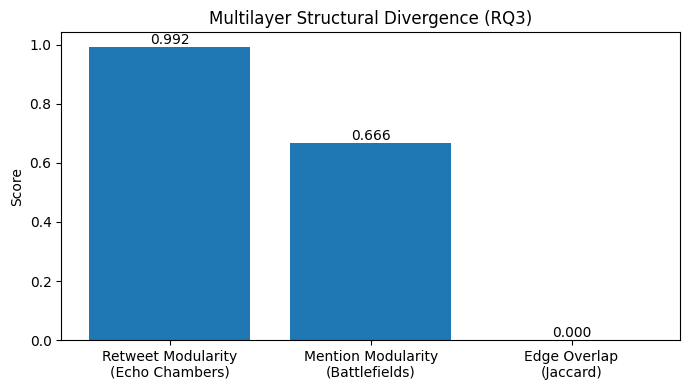

In [18]:
# Visualization 1 (BEST): Structural Comparison Dashboard
import matplotlib.pyplot as plt

labels = [
    "Retweet Modularity\n(Echo Chambers)",
    "Mention Modularity\n(Battlefields)",
    "Edge Overlap\n(Jaccard)"
]

values = [Q_rt, Q_men, jaccard_overlap]

plt.figure(figsize=(7,4))
bars = plt.bar(labels, values)

plt.ylabel("Score")
plt.title("Multilayer Structural Divergence (RQ3)")

# Annotate values
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.3f}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


Visualization 2: Multiplex Edge Overlap Diagram (Strong-Tie Focus)

This goes beyond basic Jaccard and shows how little overlap actually exists.

What it shows
RT edges only
Mention edges only
Shared edges (usually tiny)

Why this is advanced
Makes “lack of overlap” visually undeniable
Strong conceptual mapping to multiplex theory

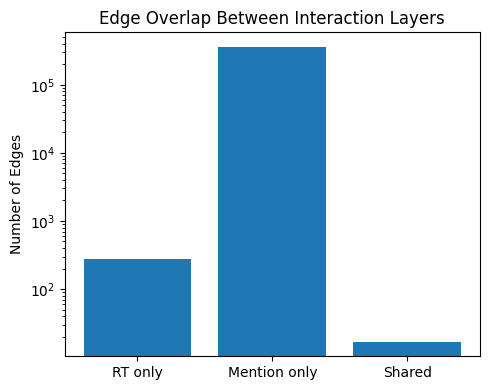

In [19]:
# Edge sets
E_rt = set(rt_edges)
E_men = set(mention_edges)

shared = len(E_rt & E_men)
rt_only = len(E_rt - E_men)
men_only = len(E_men - E_rt)

plt.figure(figsize=(5,4))
plt.bar(
    ["RT only", "Mention only", "Shared"],
    [rt_only, men_only, shared]
)

plt.ylabel("Number of Edges")
plt.title("Edge Overlap Between Interaction Layers")

plt.yscale("log")  # important: shared edges are usually tiny
plt.tight_layout()
plt.show()


Visualization 3: Community Misalignment Heat Indicator

This visualizes cross-layer inconsistency, not just edges.

What it shows
How often users remain in the same community across layers

Why it’s good
Abstract but theoretically deep
Connects to polarization theory

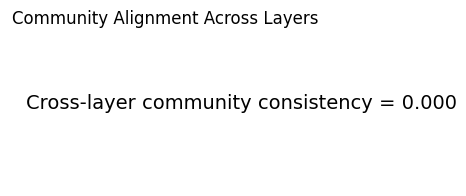

In [20]:
plt.figure(figsize=(4,2))
plt.text(
    0.05, 0.5,
    f"Cross-layer community consistency = {consistency:.3f}",
    fontsize=14
)
plt.title("Community Alignment Across Layers")
plt.axis("off")
plt.show()


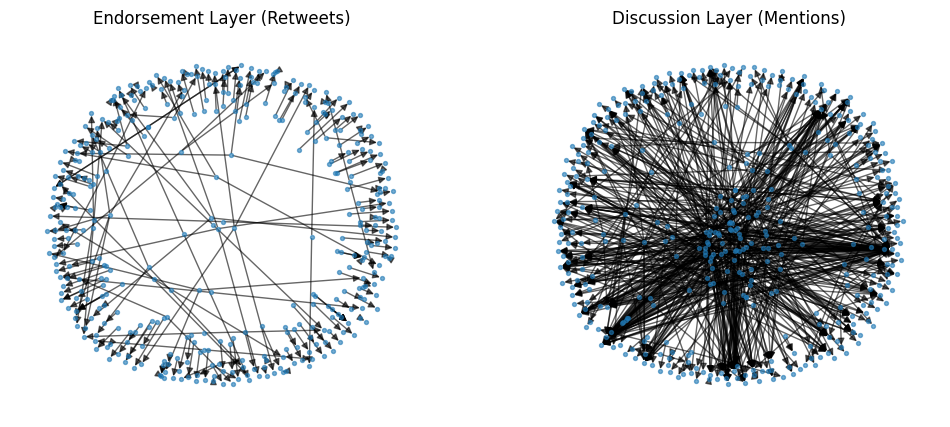

In [21]:
# OPTIONAL (Illustrative only): Side-by-Side Layer Snapshots

nodes_rt = list(G_rt.nodes())[:400]
nodes_men = list(G_men.nodes())[:400]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
nx.draw(G_rt.subgraph(nodes_rt), node_size=8, alpha=0.6)
plt.title("Endorsement Layer (Retweets)")

plt.subplot(1,2,2)
nx.draw(G_men.subgraph(nodes_men), node_size=8, alpha=0.6)
plt.title("Discussion Layer (Mentions)")

plt.show()

### RQ3 Interpretation

The retweet network exhibits higher modularity than the mention network,indicating strong ideological echo chambers in endorsement behavior. At the same time, the two layers share very few edges, suggesting that users primarily mention ideological opponents rather than allies.This supports the hypothesis that political interaction networks simultaneously function as echo chambers (trust) and battlefields (conflict).
